In [2]:
######### MODULES ##########
import sys, os, re
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [3]:
string_lst = ["a","b","c"]

'|'.join(string_lst)

'a|b|c'

In [4]:
######## FUNCTIONS #########

def read_data(shot, silent= False):
    ###FIND MATCHING FILE NAMES
    relitive_path = "data\\"
    file_names = os.listdir(relitive_path) # lists out the names of all files in the working directory
    kirills_file_names = [file_name for file_name in file_names if len(re.findall(".*SHOT"+ str(shot) + "[^0-9]*[0-9]{3}[^0-9].*.csv", file_name))]
    phils_file_names = [file_name for file_name in file_names if len(re.findall("(?i)s0*{:d}[^0-9]*\.csv".format(shot) , file_name))]
    xray_file_names = [file_name for file_name in file_names if len(re.findall(".*SHOT{:d}.tif".format(shot) , file_name))]
    filtered_file_names = kirills_file_names + phils_file_names + xray_file_names
    ###PRINT FILE INFO
    if not silent: # remember to do silent == True if you use read_data in a loop
        print("Found {:d} files:".format(len(filtered_file_names)))
        [print("   " + filtered_file_name) for filtered_file_name in filtered_file_names]
    ###PUT OSCILLOSCOPE FILES INTO DICTIONARY
    dictionary = {}
    for phils_file_name in phils_file_names: # should only be 1 file
        for n, column in enumerate(["time","bdot","tof","diode"]): # some data files have Ch4 but it's just noise.
            dictionary[column] = np.genfromtxt(relitive_path+phils_file_name, delimiter=',', skip_header =18, usecols=n)
    ###PUT THZ FILES INTO DICTIONARY
    # for kirill_file_name in kirills_file_names: # should only be 2 files
    #     channel = "gentec" if "Ch1" in kirill_file_name else "custom"
    #     dictionary[channel + "_time"], dictionary[channel] = np.genfromtxt(relitive_path+kirill_file_name, delimiter=',', skip_header =0, usecols=(3,4)).T
    for kirill_file_name in kirills_file_names: # should only be 2 files
        if "Ch1" in kirill_file_name:
            channel = "Ch1"
        elif "Ch2" in kirill_file_name:
            channel = "Ch2"
        elif "Ch3" in kirill_file_name:
            channel = "Ch3"
        elif "Ch4" in kirill_file_name:
            channel = "Ch4"
        dictionary["pyro_time"], dictionary[channel] = np.genfromtxt(relitive_path+kirill_file_name, delimiter=',', skip_header =0, usecols=(3,4)).T
    ###PUT XRAY FILES INTO DICTIONARY
    for xray_file_name in xray_file_names: # should only be 2 files
        raw = "_raw" if "raw" in xray_file_name else ""
        dictionary["xray" + raw] = np.array(Image.open(relitive_path+xray_file_name))

    return dictionary

def read_lots_of_data(shots, requested_data, silent= False): #read_data is too slow because it reads all files
    relitive_path = "data\\"
    file_names = os.listdir(relitive_path) # lists out the names of all files in the working directory
    shots = np.array([str(shot) for shot in shots])
    dictionary = {}
    oscilloscope_data = ["time","bdot","tof","diode"]

    if requested_data in ["Ch1","pyro_time"]:
        filtered_file_names = [file_name for file_name in file_names if len(re.findall(".*SHOT("+'|'.join(shots)+")[^0-9]*[0-9]{3}[^0-9].*Ch1.csv", file_name))]
        for filtered_file_name in filtered_file_names:
            dictionary[filtered_file_name] = np.genfromtxt(relitive_path+filtered_file_name, delimiter=',', skip_header =0, usecols= 3 if requested_data == "gentec_time" else 4)

    elif requested_data in ["Ch2","pyro_time"]:
        filtered_file_names = [file_name for file_name in file_names if len(re.findall(".*SHOT("+'|'.join(shots)+")[^0-9]*[0-9]{3}[^0-9].*Ch2.csv", file_name))]
        for filtered_file_name in filtered_file_names:
            dictionary[filtered_file_name] = np.genfromtxt(relitive_path+filtered_file_name, delimiter=',', skip_header =0, usecols= 3 if requested_data == "custom_time" else 4)
    elif requested_data in ["Ch3","pyro_time"]:
        filtered_file_names = [file_name for file_name in file_names if len(re.findall(".*SHOT("+'|'.join(shots)+")[^0-9]*[0-9]{3}[^0-9].*Ch3.csv", file_name))]
        for filtered_file_name in filtered_file_names:
            dictionary[filtered_file_name] = np.genfromtxt(relitive_path+filtered_file_name, delimiter=',', skip_header =0, usecols= 3 if requested_data == "custom_time" else 4)
    elif requested_data in ["Ch4","pyro_time"]:
        filtered_file_names = [file_name for file_name in file_names if len(re.findall(".*SHOT("+'|'.join(shots)+")[^0-9]*[0-9]{3}[^0-9].*Ch4.csv", file_name))]
        for filtered_file_name in filtered_file_names:
            dictionary[filtered_file_name] = np.genfromtxt(relitive_path+filtered_file_name, delimiter=',', skip_header =0, usecols= 3 if requested_data == "custom_time" else 4)

    elif requested_data in oscilloscope_data:
        filtered_file_names = [file_name for file_name in file_names if len(re.findall("(?i)s0*("+'|'.join(shots)+")[^0-9]*\.csv", file_name))]
        for filtered_file_name in filtered_file_names:
            column = oscilloscope_data.index(requested_data)
            dictionary[filtered_file_name] = np.genfromtxt(relitive_path+filtered_file_name, delimiter=',', skip_header =18, usecols= column)

    elif requested_data in ["xray", "xray_raw"]:
        filtered_file_names = [file_name for file_name in file_names if len(re.findall(".*SHOT("+'|'.join(shots)+").tif", file_name))]
        raw = [True if "raw" in filtered_file_name else False for filtered_file_name in filtered_file_names]
        if requested_data == "xray":
            filtered_file_names = np.array(filtered_file_names)[np.logical_not(raw)]
        else:
            filtered_file_names = np.array(filtered_file_names)[raw]
        for filtered_file_name in filtered_file_names: # should only be 2 files
            dictionary[filtered_file_name] = np.array(Image.open(relitive_path+filtered_file_name))

    if not silent: # remember to do silent == True if you use read_data in a loop
        print("Found {:d} files:".format(len(filtered_file_names)))
        [print("   " + filtered_file_name) for filtered_file_name in filtered_file_names]

    return dictionary


Found 7 files:
   260124WIRESHOT71000_Ch1.csv
   260124WIRESHOT71000_Ch2.csv
   260124WIRESHOT71000_Ch3.csv
   260124WIRESHOT71000_Ch4.csv
   s71_ALL.csv
   2024 janvier 26 15_53_35 SHOT71.tif
   2024 janvier 26 15_53_35-raw SHOT71.tif
1144401200.0


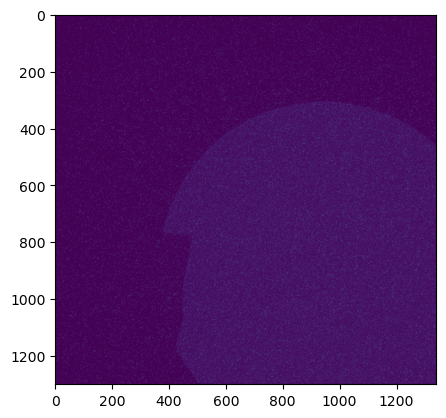

In [132]:
Ximage=read_data(71)["xray"]
Xsumm=np.sum(Ximage)
print(Xsumm)
plt.imshow(Ximage)

In [86]:
read_data(71)

Found 7 files:
   260124WIRESHOT71000_Ch1.csv
   260124WIRESHOT71000_Ch2.csv
   260124WIRESHOT71000_Ch3.csv
   260124WIRESHOT71000_Ch4.csv
   s71_ALL.csv
   2024 janvier 26 15_53_35 SHOT71.tif
   2024 janvier 26 15_53_35-raw SHOT71.tif


{'time': array([-1.1999125e-07, -1.1997125e-07, -1.1995125e-07, ...,
         8.7994875e-07,  8.7996875e-07,  8.7998875e-07]),
 'bdot': array([-1.625000e-03,  9.375000e-05,  1.828125e-03, ...,  2.328125e-03,
        -2.812500e-04, -2.828125e-03]),
 'tof': array([-0.01446875, -0.01596875, -0.01428125, ..., -0.0135    ,
        -0.01328125, -0.01371875]),
 'diode': array([ 0.00010938,  0.        , -0.00010938, ...,  0.        ,
         0.        ,  0.        ]),
 'pyro_time': array([-0.025   , -0.024995, -0.02499 , ...,  0.024985,  0.02499 ,
         0.024995]),
 'Ch1': array([-3.81469727e-08,  3.99999619e-02, -3.81469727e-08, ...,
         3.99999619e-02,  5.99999619e-02,  3.99999619e-02]),
 'Ch2': array([-0.016, -0.016, -0.032, ...,  0.032,  0.048,  0.032]),
 'Ch3': array([0.064, 0.064, 0.064, ..., 0.064, 0.048, 0.024]),
 'Ch4': array([-0.128, -0.072, -0.016, ..., -0.248, -0.176, -0.096]),
 'xray': array([[ 2.000e+00, -8.000e+00, -2.700e+01, ...,  2.300e+01,  7.200e+01,
          2.64

Found 4 files:
   290124WIRESHOT211000_Ch1.csv
   290124WIRESHOT211000_Ch2.csv
   290124WIRESHOT211000_Ch3.csv
   290124WIRESHOT211000_Ch4.csv
Found 4 files:
   290124WIRESHOT211000_Ch1.csv
   290124WIRESHOT211000_Ch2.csv
   290124WIRESHOT211000_Ch3.csv
   290124WIRESHOT211000_Ch4.csv
Found 4 files:
   290124WIRESHOT211000_Ch1.csv
   290124WIRESHOT211000_Ch2.csv
   290124WIRESHOT211000_Ch3.csv
   290124WIRESHOT211000_Ch4.csv
Found 4 files:
   290124WIRESHOT211000_Ch1.csv
   290124WIRESHOT211000_Ch2.csv
   290124WIRESHOT211000_Ch3.csv
   290124WIRESHOT211000_Ch4.csv
Found 4 files:
   290124WIRESHOT211000_Ch1.csv
   290124WIRESHOT211000_Ch2.csv
   290124WIRESHOT211000_Ch3.csv
   290124WIRESHOT211000_Ch4.csv
Found 4 files:
   290124WIRESHOT211000_Ch1.csv
   290124WIRESHOT211000_Ch2.csv
   290124WIRESHOT211000_Ch3.csv
   290124WIRESHOT211000_Ch4.csv
Found 4 files:
   290124WIRESHOT211000_Ch1.csv
   290124WIRESHOT211000_Ch2.csv
   290124WIRESHOT211000_Ch3.csv
   290124WIRESHOT211000_Ch4.csv

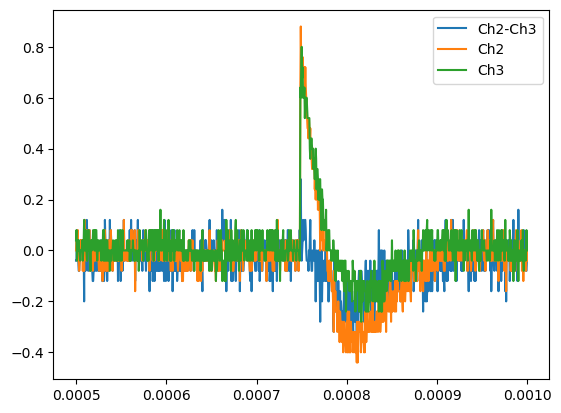

In [23]:
ShotN=211
timeMIN=6000
timeMAX=7000
array_time = read_data(ShotN)["pyro_time"]
array_data = read_data(ShotN)["Ch2"]
array_data_EMP= read_data(ShotN)["Ch3"]

# plt.plot(array_time[timeMIN:timeMAX], array_data[timeMIN:timeMAX], label="Ch1")
# print(array_data.shape)
plt.plot(array_time[timeMIN:timeMAX], array_data[timeMIN:timeMAX]-array_data_EMP[timeMIN:timeMAX], label="Ch2-Ch3")
array_time = read_data(ShotN)["pyro_time"]
array_data = read_data(ShotN)["Ch2"]
plt.plot(array_time[timeMIN:timeMAX], array_data[timeMIN:timeMAX], label ="Ch2")
array_time = read_data(ShotN)["pyro_time"]
array_data = read_data(ShotN)["Ch3"]
plt.plot(array_time[timeMIN:timeMAX], array_data[timeMIN:timeMAX], label ="Ch3")
# array_time = read_data(ShotN)["pyro_time"]
# array_data = read_data(ShotN)["Ch4"]
# plt.plot(array_time[10000:10300], array_data[10000:10300], label ="Ch4")
plt.legend()
plt.legend()


In [70]:
shot_max = 196
shot_min = 158
#bdot_maxs, shot_number_bdot = np.array([[np.max(read_data(shot= shot, silent= True)["bdot"]), shot] for shot in np.arange(shot_min, shot_max) if "bdot" in read_data(shot= shot, silent= True)]).T
Ch1, shot_number_pyro = np.array([[np.abs(np.min(read_data(shot= shot, silent= True)["Ch1"])), shot] for shot in np.arange(shot_min, shot_max) if "Ch1" in read_data(shot= shot, silent= True)]).T
Ch2, shot_number_pyro = np.array([[np.abs(np.min(read_data(shot= shot, silent= True)["Ch2"])), shot] for shot in np.arange(shot_min, shot_max) if "Ch2" in read_data(shot= shot, silent= True)]).T
Ch3, shot_number_pyro = np.array([[np.abs(np.min(read_data(shot= shot, silent= True)["Ch3"])), shot] for shot in np.arange(shot_min, shot_max) if "Ch3" in read_data(shot= shot, silent= True)]).T
Ch4, shot_number_pyro = np.array([[np.abs(np.min(read_data(shot= shot, silent= True)["Ch4"])), shot] for shot in np.arange(shot_min, shot_max) if "Ch4" in read_data(shot= shot, silent= True)]).T
#Xray, shot_number_Xray = np.array([[np.sum(read_data(shot= shot, silent= True)["xray"]), shot] for shot in np.arange(shot_min, shot_max) if "xray" in read_data(shot= shot, silent= True)]).T

#print(Xray)

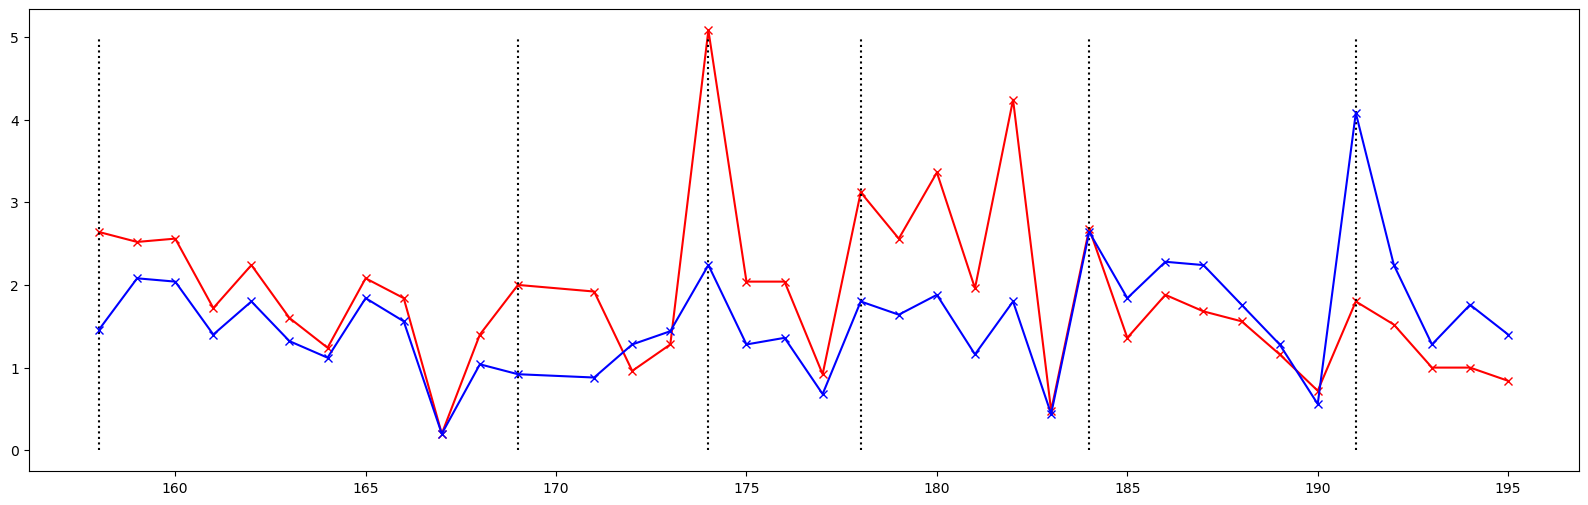

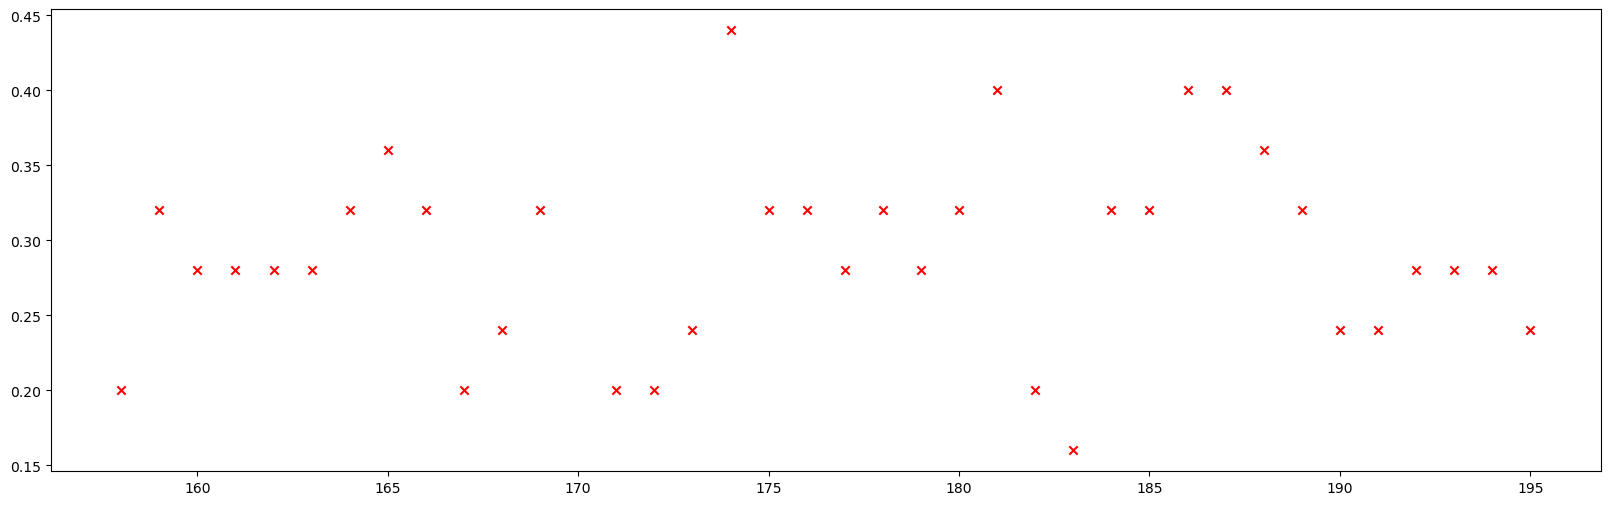

In [71]:
plt.figure(figsize=(20,6))
plt.plot(shot_number_pyro, Ch2, color="red", alpha=1, label="QMC pyro", marker="x")

#plt.twinx()
plt.vlines(191, 0, 5, linestyles ="dotted", colors ="k")
plt.vlines(184, 0, 5, linestyles ="dotted", colors ="k")
plt.vlines(174, 0, 5, linestyles ="dotted", colors ="k")
plt.vlines(178, 0, 5, linestyles ="dotted", colors ="k")
plt.vlines(169, 0, 5, linestyles ="dotted", colors ="k")
plt.vlines(158, 0, 5, linestyles ="dotted", colors ="k")


plt.plot(shot_number_pyro, Ch3, color="blue", alpha=1, label="QMC pyro", marker="x")


plt.figure(figsize=(20,6))

plt.scatter(shot_number_pyro, Ch1, color="red", alpha=1, label="QMC pyro", marker="x")



In [25]:
shot_max = 236
shot_min = 211
#bdot_maxs, shot_number_bdot = np.array([[np.max(read_data(shot= shot, silent= True)["bdot"]), shot] for shot in np.arange(shot_min, shot_max) if "bdot" in read_data(shot= shot, silent= True)]).T
Ch1, shot_number_pyro = np.array([[np.abs(np.min(read_data(shot= shot, silent= True)["Ch1"])), shot] for shot in np.arange(shot_min, shot_max) if "Ch1" in read_data(shot= shot, silent= True)]).T
Ch2, shot_number_pyro = np.array([[np.abs(np.min(read_data(shot= shot, silent= True)["Ch2"])), shot] for shot in np.arange(shot_min, shot_max) if "Ch2" in read_data(shot= shot, silent= True)]).T
Ch3, shot_number_pyro = np.array([[np.abs(np.min(read_data(shot= shot, silent= True)["Ch3"])), shot] for shot in np.arange(shot_min, shot_max) if "Ch3" in read_data(shot= shot, silent= True)]).T
Ch4, shot_number_pyro = np.array([[np.abs(np.min(read_data(shot= shot, silent= True)["Ch4"])), shot] for shot in np.arange(shot_min, shot_max) if "Ch4" in read_data(shot= shot, silent= True)]).T
#Xray, shot_number_Xray = np.array([[np.sum(read_data(shot= shot, silent= True)["xray"]), shot] for shot in np.arange(shot_min, shot_max) if "xray" in read_data(shot= shot, silent= True)]).T

#print(Xray)

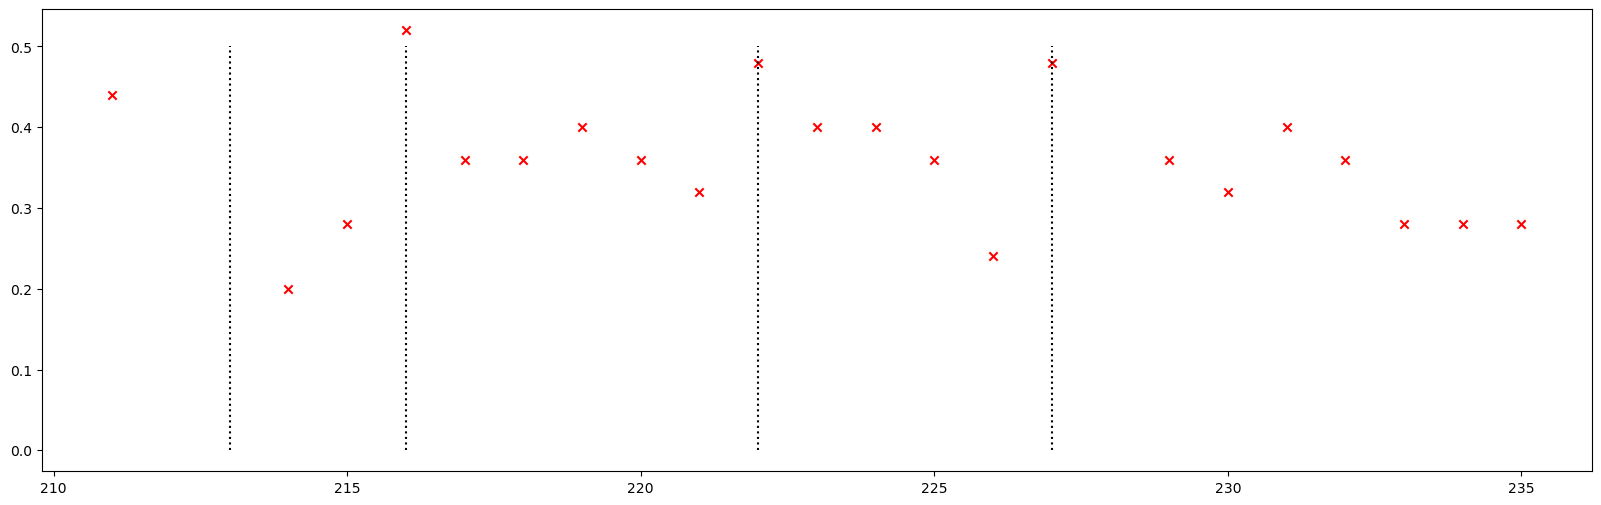

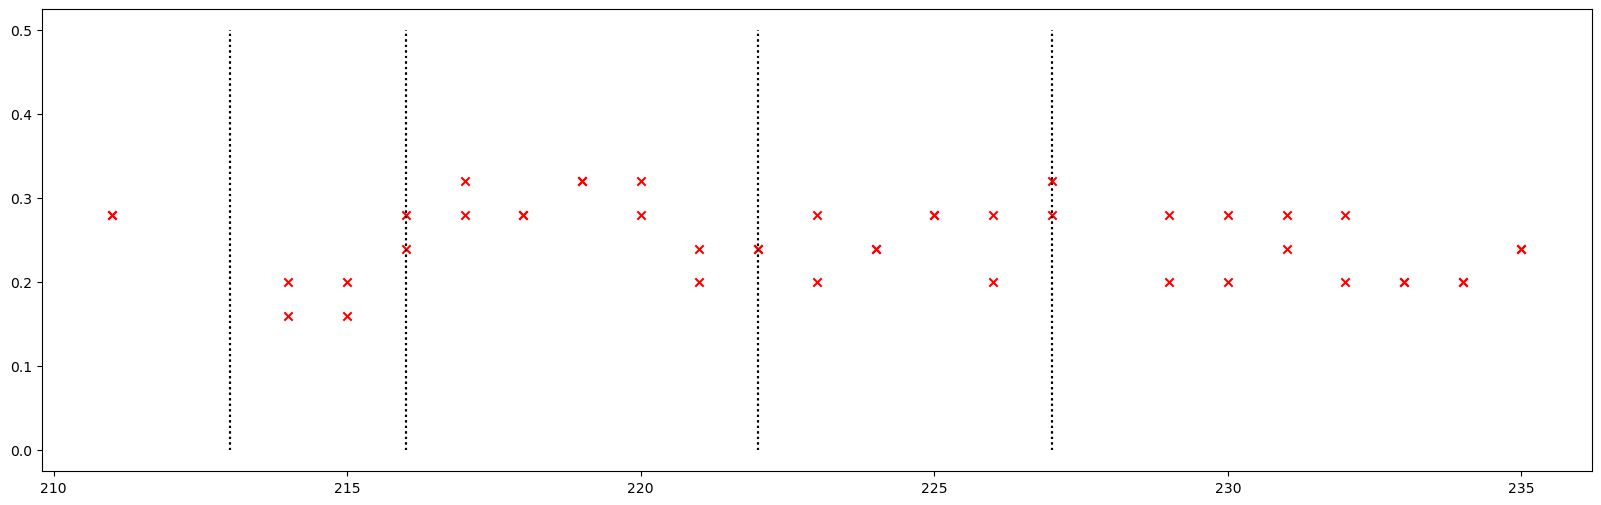

In [43]:
plt.figure(figsize=(20,6))
plt.scatter(shot_number_pyro, Ch2, color="red", alpha=1, label="QMC pyro", marker="x")

plt.vlines(213, 0, 0.5, linestyles ="dotted", colors ="k")
plt.vlines(222, 0, 0.5, linestyles ="dotted", colors ="k")
plt.vlines(227, 0, 0.5, linestyles ="dotted", colors ="k")
plt.vlines(216, 0, 0.5, linestyles ="dotted", colors ="k")
plt.figure(figsize=(20,6))
plt.scatter(shot_number_pyro, Ch3, color="red", alpha=1, label="QMC pyro", marker="x")

plt.vlines(213, 0, 0.5, linestyles ="dotted", colors ="k")
plt.vlines(222, 0, 0.5, linestyles ="dotted", colors ="k")
plt.vlines(227, 0, 0.5, linestyles ="dotted", colors ="k")
plt.vlines(216, 0, 0.5, linestyles ="dotted", colors ="k")

plt.scatter(shot_number_pyro, Ch1, color="red", alpha=1, label="QMC pyro", marker="x")

plt.vlines(213, 0, 0.5, linestyles ="dotted", colors ="k")
plt.vlines(222, 0, 0.5, linestyles ="dotted", colors ="k")
plt.vlines(227, 0, 0.5, linestyles ="dotted", colors ="k")
plt.vlines(216, 0, 0.5, linestyles ="dotted", colors ="k")
# plt.vlines(136, 0, 0.5, linestyles ="dotted", colors ="k")
# print(laseren.shape)
# print(shot_number_pyro)
# print(shot_number_pyro.shape)
# plt.plot(shot_number_pyro, laseren/3, label="Energy/3")
# plt.ylabel("QMC pyro (V) and Energy/3")
# plt.xlabel("shot number")
# plt.legend()
# plt.twinx()
# plt.scatter(shot_number_pyro[4:], Ch3[4:], color="green", alpha=1, label="Pyro3",marker="x")
# plt.ylim(0)
# plt.xlabel("shot number")
# plt.ylabel("Custom Pyro (V)")
# plt.legend()
# plt.show()

Found 4 files:
   290124WIRESHOT136000_Ch1.csv
   290124WIRESHOT136000_Ch2.csv
   290124WIRESHOT136000_Ch3.csv
   290124WIRESHOT136000_Ch4.csv
Found 4 files:
   290124WIRESHOT136000_Ch1.csv
   290124WIRESHOT136000_Ch2.csv
   290124WIRESHOT136000_Ch3.csv
   290124WIRESHOT136000_Ch4.csv
Found 4 files:
   290124WIRESHOT136000_Ch1.csv
   290124WIRESHOT136000_Ch2.csv
   290124WIRESHOT136000_Ch3.csv
   290124WIRESHOT136000_Ch4.csv
Found 4 files:
   290124WIRESHOT136000_Ch1.csv
   290124WIRESHOT136000_Ch2.csv
   290124WIRESHOT136000_Ch3.csv
   290124WIRESHOT136000_Ch4.csv
Found 4 files:
   290124WIRESHOT136000_Ch1.csv
   290124WIRESHOT136000_Ch2.csv
   290124WIRESHOT136000_Ch3.csv
   290124WIRESHOT136000_Ch4.csv
Found 4 files:
   290124WIRESHOT136000_Ch1.csv
   290124WIRESHOT136000_Ch2.csv
   290124WIRESHOT136000_Ch3.csv
   290124WIRESHOT136000_Ch4.csv
Found 4 files:
   290124WIRESHOT136000_Ch1.csv
   290124WIRESHOT136000_Ch2.csv
   290124WIRESHOT136000_Ch3.csv
   290124WIRESHOT136000_Ch4.csv

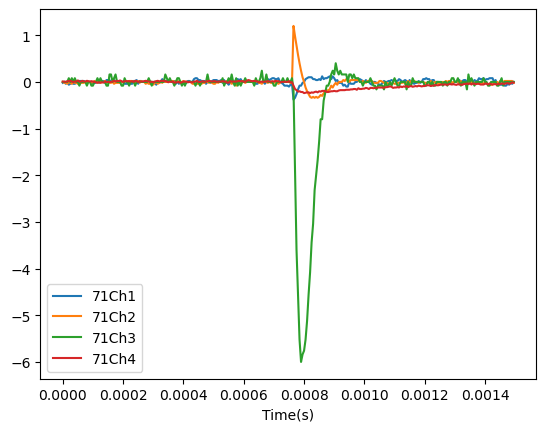

In [300]:
shoN=136
array_data_EMP = read_data(shoN)["Ch2"]

array_time = read_data(shoN)["pyro_time"]
array_data = read_data(shoN)["Ch1"]
plt.plot(array_time[1000:1300], array_data[1000:1300]-array_data_EMP[1000:1300], label="71Ch1")
array_time = read_data(shoN)["pyro_time"]
array_data = read_data(shoN)["Ch2"]
plt.plot(array_time[1000:1300], array_data[1000:1300], label="71Ch2")
array_time = read_data(shoN)["pyro_time"]
array_data = read_data(shoN)["Ch3"]
plt.plot(array_time[1000:1300], array_data[1000:1300], label="71Ch3")
array_time = read_data(shoN)["pyro_time"]
array_data = read_data(shoN)["Ch4"]
plt.plot(array_time[1000:1300], array_data[1000:1300], label="71Ch4")
plt.xlabel("Time(s)")

plt.legend()
plt.legend()

Found 4 files:
   290124WIRESHOT110000_Ch1.csv
   290124WIRESHOT110000_Ch2.csv
   290124WIRESHOT110000_Ch3.csv
   290124WIRESHOT110000_Ch4.csv
Found 4 files:
   290124WIRESHOT110000_Ch1.csv
   290124WIRESHOT110000_Ch2.csv
   290124WIRESHOT110000_Ch3.csv
   290124WIRESHOT110000_Ch4.csv
Found 4 files:
   290124WIRESHOT110000_Ch1.csv
   290124WIRESHOT110000_Ch2.csv
   290124WIRESHOT110000_Ch3.csv
   290124WIRESHOT110000_Ch4.csv


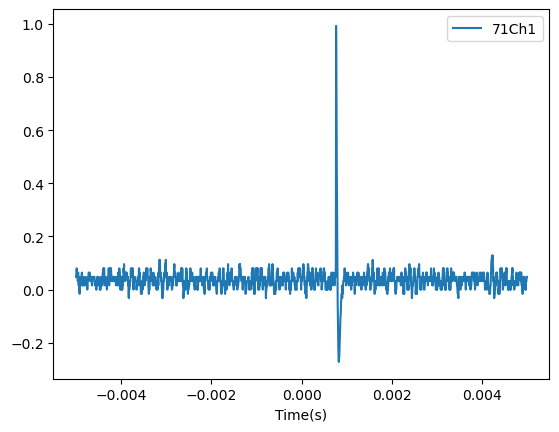

In [299]:
shoN=110
array_data_EMP = read_data(shoN)["Ch2"]

array_time = read_data(shoN)["pyro_time"]
array_data = read_data(shoN)["Ch1"]
plt.plot(array_time[:], array_data[:], label="71Ch1")
# array_time = read_data(shoN)["pyro_time"]
# array_data = read_data(shoN)["Ch2"]
# plt.plot(array_time[1000:1300], array_data[1000:1300], label="71Ch2")
# array_time = read_data(shoN)["pyro_time"]
# array_data = read_data(shoN)["Ch3"]
# plt.plot(array_time[1000:1300], array_data[1000:1300], label="71Ch3")
# array_time = read_data(shoN)["pyro_time"]
# array_data = read_data(shoN)["Ch4"]
# plt.plot(array_time[1000:1300], array_data[1000:1300], label="71Ch4")
plt.xlabel("Time(s)")

plt.legend()
plt.legend()

In [47]:
shot_max = 137
shot_min = 107
#bdot_maxs, shot_number_bdot = np.array([[np.max(read_data(shot= shot, silent= True)["bdot"]), shot] for shot in np.arange(shot_min, shot_max) if "bdot" in read_data(shot= shot, silent= True)]).T
Ch1, shot_number_pyro = np.array([[np.abs(np.max(read_data(shot= shot, silent= True)["Ch1"])), shot] for shot in np.arange(shot_min, shot_max) if "Ch1" in read_data(shot= shot, silent= True)]).T
Ch2, shot_number_pyro = np.array([[np.abs(np.max(read_data(shot= shot, silent= True)["Ch2"])), shot] for shot in np.arange(shot_min, shot_max) if "Ch2" in read_data(shot= shot, silent= True)]).T
Ch3, shot_number_pyro = np.array([[np.abs(np.min(read_data(shot= shot, silent= True)["Ch3"])), shot] for shot in np.arange(shot_min, shot_max) if "Ch3" in read_data(shot= shot, silent= True)]).T
Ch4, shot_number_pyro = np.array([[np.abs(np.min(read_data(shot= shot, silent= True)["Ch4"])), shot] for shot in np.arange(shot_min, shot_max) if "Ch4" in read_data(shot= shot, silent= True)]).T
#Xray, shot_number_Xray = np.array([[np.sum(read_data(shot= shot, silent= True)["xray"]), shot] for shot in np.arange(shot_min, shot_max) if "xray" in read_data(shot= shot, silent= True)]).T

#print(Xray)

(30,)
[107. 108. 109. 110. 111. 112. 113. 114. 115. 116. 117. 118. 119. 120.
 121. 122. 123. 124. 125. 126. 127. 128. 129. 130. 131. 132. 133. 134.
 135. 136.]
(30,)


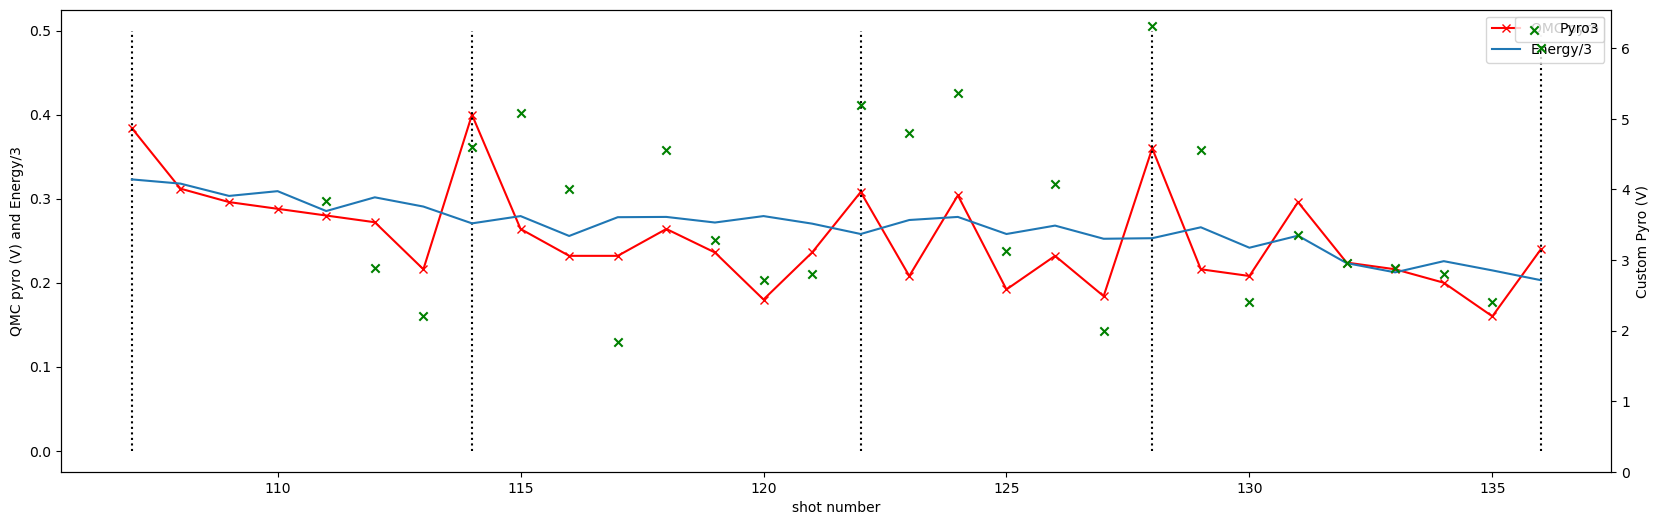

In [48]:

plt.figure(figsize=(20,6))
plt.plot(shot_number_pyro, Ch4, color="red", alpha=1, label="QMC pyro", marker="x")
plt.vlines(107, 0, 0.5, linestyles ="dotted", colors ="k")
plt.vlines(114, 0, 0.5, linestyles ="dotted", colors ="k")
plt.vlines(122, 0, 0.5, linestyles ="dotted", colors ="k")
plt.vlines(128, 0, 0.5, linestyles ="dotted", colors ="k")
plt.vlines(136, 0, 0.5, linestyles ="dotted", colors ="k")
laseren=np.array([0.969,0.954,0.91,0.927,0.856,0.905,0.872,0.812,0.838,0.767,0.834,0.835,0.815,0.838,0.811,0.774,0.824,0.835,0.774,0.804,0.757,0.759,0.798,0.725,0.768,0.67,0.637,0.677, 0.644,0.609])
print(laseren.shape)
print(shot_number_pyro)
print(shot_number_pyro.shape)
plt.plot(shot_number_pyro, laseren/3, label="Energy/3")
plt.ylabel("QMC pyro (V) and Energy/3")
plt.xlabel("shot number")
plt.legend()
plt.twinx()
plt.scatter(shot_number_pyro[4:], Ch3[4:], color="green", alpha=1, label="Pyro3",marker="x")
plt.ylim(0)
plt.xlabel("shot number")
plt.ylabel("Custom Pyro (V)")
plt.legend()
plt.show()

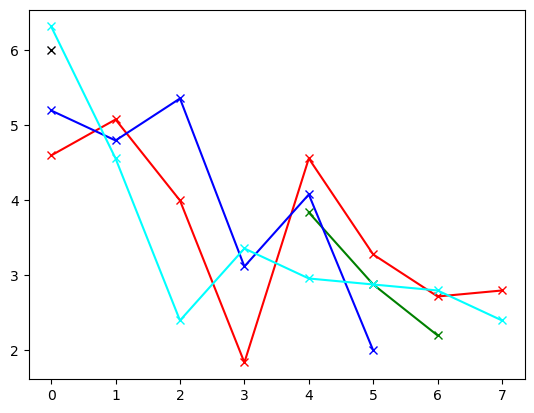

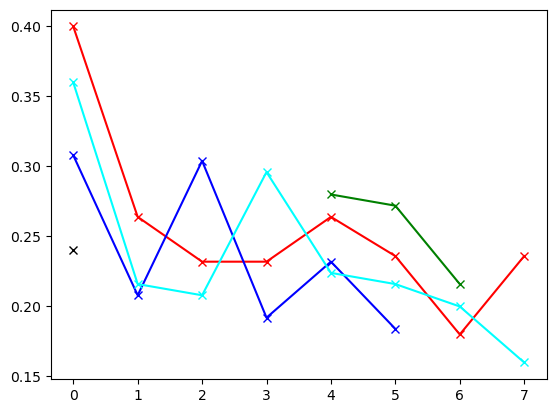

In [50]:
adj=[4,5,6]
plt.plot(adj,Ch3[4:7], color="green", alpha=1, label="Pyro3",marker="x")
plt.plot(Ch3[7:15], color="red", alpha=1, label="Pyro3",marker="x")
plt.plot(Ch3[15:21], color="blue", alpha=1, label="Pyro3",marker="x")
plt.plot(Ch3[21:29], color="cyan", alpha=1, label="Pyro3",marker="x")
plt.plot(Ch3[29:31], color="black", alpha=1, label="Pyro3",marker="x")
plt.show()
adj=[4,5,6]
plt.plot(adj,Ch4[4:7], color="green", alpha=1, label="Pyro3",marker="x")
plt.plot(Ch4[7:15], color="red", alpha=1, label="Pyro3",marker="x")
plt.plot(Ch4[15:21], color="blue", alpha=1, label="Pyro3",marker="x")
plt.plot(Ch4[21:29], color="cyan", alpha=1, label="Pyro3",marker="x")
plt.plot(Ch4[29:31], color="black", alpha=1, label="Pyro3",marker="x")


Found 7 files:
   260124WIRESHOT71000_Ch1.csv
   260124WIRESHOT71000_Ch2.csv
   260124WIRESHOT71000_Ch3.csv
   260124WIRESHOT71000_Ch4.csv
   s71_ALL.csv
   2024 janvier 26 15_53_35 SHOT71.tif
   2024 janvier 26 15_53_35-raw SHOT71.tif
Found 7 files:
   260124WIRESHOT71000_Ch1.csv
   260124WIRESHOT71000_Ch2.csv
   260124WIRESHOT71000_Ch3.csv
   260124WIRESHOT71000_Ch4.csv
   s71_ALL.csv
   2024 janvier 26 15_53_35 SHOT71.tif
   2024 janvier 26 15_53_35-raw SHOT71.tif
(10000,)
Found 7 files:
   260124WIRESHOT71000_Ch1.csv
   260124WIRESHOT71000_Ch2.csv
   260124WIRESHOT71000_Ch3.csv
   260124WIRESHOT71000_Ch4.csv
   s71_ALL.csv
   2024 janvier 26 15_53_35 SHOT71.tif
   2024 janvier 26 15_53_35-raw SHOT71.tif
Found 7 files:
   260124WIRESHOT71000_Ch1.csv
   260124WIRESHOT71000_Ch2.csv
   260124WIRESHOT71000_Ch3.csv
   260124WIRESHOT71000_Ch4.csv
   s71_ALL.csv
   2024 janvier 26 15_53_35 SHOT71.tif
   2024 janvier 26 15_53_35-raw SHOT71.tif
Found 7 files:
   260124WIRESHOT71000_Ch1.csv
 

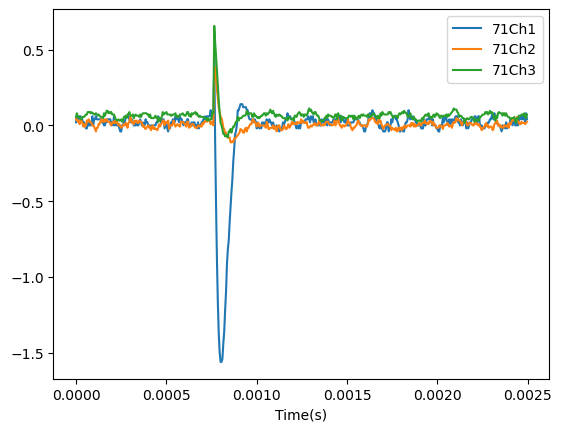

In [91]:
array_time = read_data(71)["pyro_time"]
array_data = read_data(71)["Ch1"]
print(array_data.shape)
plt.plot(array_time[5000:5500], array_data[5000:5500], label="71Ch1")
array_time = read_data(71)["pyro_time"]
array_data = read_data(71)["Ch2"]
plt.plot(array_time[5000:5500], array_data[5000:5500], label="71Ch2")
array_time = read_data(71)["pyro_time"]
array_data = read_data(71)["Ch3"]
plt.plot(array_time[5000:5500], array_data[5000:5500], label="71Ch3")
plt.xlabel("Time(s)")

plt.legend()
plt.legend()

In [94]:
shot_max = 76
shot_min = 71
bdot_maxs, shot_number_bdot = np.array([[np.max(read_data(shot= shot, silent= True)["bdot"]), shot] for shot in np.arange(shot_min, shot_max) if "bdot" in read_data(shot= shot, silent= True)]).T
pyro_maxs, shot_number_pyro = np.array([[np.max(read_data(shot= shot, silent= True)["Ch2"]), shot] for shot in np.arange(shot_min, shot_max) if "Ch2" in read_data(shot= shot, silent= True)]).T
pyro_mins, shot_number_pyro = np.array([[np.abs(np.min(read_data(shot= shot, silent= True)["Ch1"])), shot] for shot in np.arange(shot_min, shot_max) if "Ch1" in read_data(shot= shot, silent= True)]).T
print(pyro_maxs)
print(pyro_mins)

[0.39200001 0.32800001 0.20800001 0.112     ]
[1.56000004 1.32000004 1.60000004 1.08000004]


[1.56000004 1.32000004 1.60000004 1.08000004]


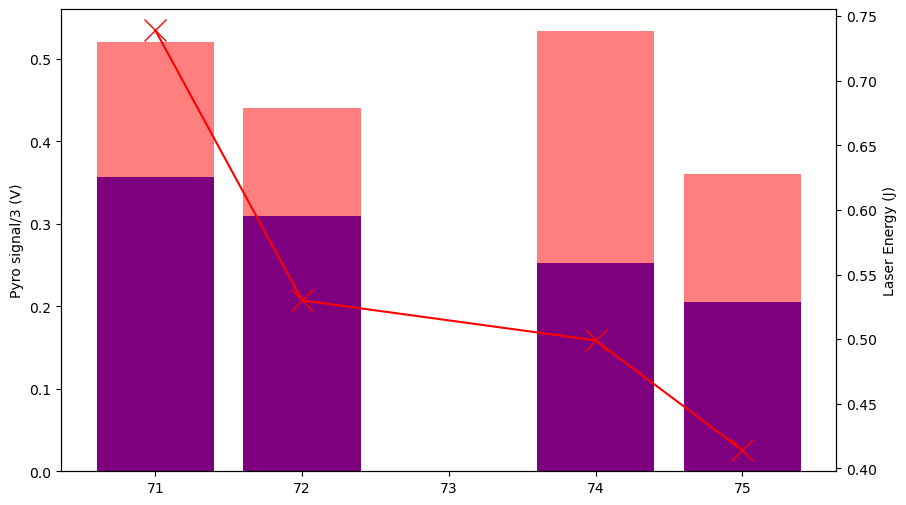

[0.48312754 0.58322524 0.50666959 0.496641  ]


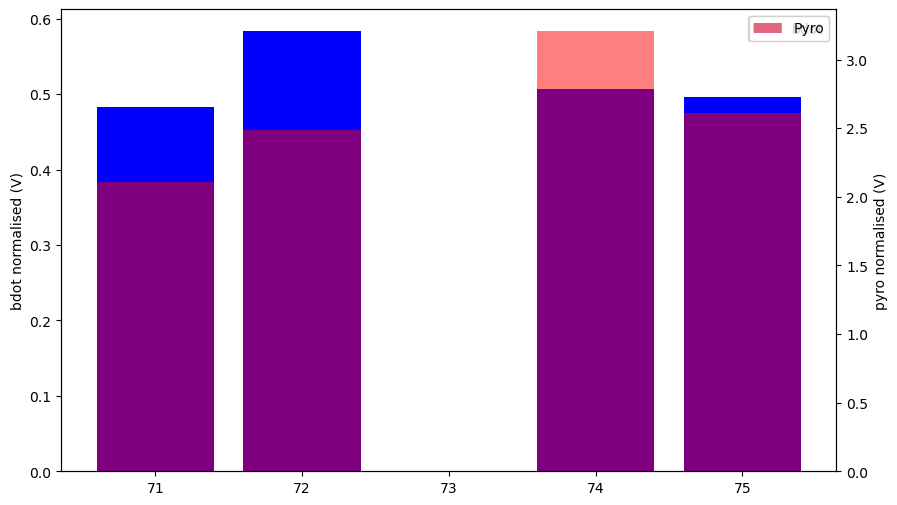

In [96]:
energies=[0.739,0.53,0.499,0.414]
print(pyro_mins)
plt.figure(figsize= (10,6))

plt.bar(shot_number_bdot, bdot_maxs, color="blue")
plt.bar(shot_number_pyro, pyro_mins/3, color="red", alpha=0.5)
plt.ylabel("Pyro signal/3 (V)")
plt.twinx()
plt.plot(shot_number_pyro,energies, marker="x", markersize=16, color="red")
plt.xlabel("shot number")
plt.ylabel("Laser Energy (J)")

plt.show()
plt.figure(figsize= (10,6))
bdot_norm=bdot_maxs/energies
pyro_mins_norm=pyro_mins/energies
print(bdot_norm)
plt.bar(shot_number_bdot, bdot_norm, color="blue", label="bdot")
plt.legend()
plt.ylabel("bdot normalised (V)")
plt.twinx()
plt.bar(shot_number_pyro, pyro_mins_norm, color="red", alpha=0.5, label="Pyro")
plt.xlabel("shot number")
plt.ylabel("pyro normalised (V)")
plt.legend()



In [137]:
shot_max = 76
shot_min = 71
bdot_maxs, shot_number_bdot = np.array([[np.max(read_data(shot= shot, silent= True)["bdot"]), shot] for shot in np.arange(shot_min, shot_max) if "bdot" in read_data(shot= shot, silent= True)]).T
Ch1, shot_number_pyro = np.array([[np.abs(np.min(read_data(shot= shot, silent= True)["Ch1"])), shot] for shot in np.arange(shot_min, shot_max) if "Ch1" in read_data(shot= shot, silent= True)]).T
Ch2, shot_number_pyro = np.array([[np.abs(np.max(read_data(shot= shot, silent= True)["Ch2"])), shot] for shot in np.arange(shot_min, shot_max) if "Ch2" in read_data(shot= shot, silent= True)]).T
Ch3, shot_number_pyro = np.array([[np.abs(np.max(read_data(shot= shot, silent= True)["Ch3"])), shot] for shot in np.arange(shot_min, shot_max) if "Ch3" in read_data(shot= shot, silent= True)]).T
Ch4, shot_number_pyro = np.array([[np.abs(np.min(read_data(shot= shot, silent= True)["Ch4"])), shot] for shot in np.arange(shot_min, shot_max) if "Ch4" in read_data(shot= shot, silent= True)]).T
Xray, shot_number_Xray = np.array([[np.sum(read_data(shot= shot, silent= True)["xray"]), shot] for shot in np.arange(shot_min, shot_max) if "xray" in read_data(shot= shot, silent= True)]).T

print(Xray)


[1.14440115e+09 1.18367437e+09 8.10216512e+08 4.90477248e+08]


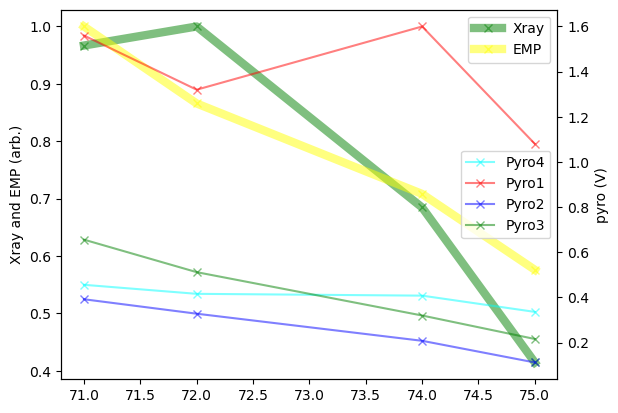

In [148]:
#plt.plot(shot_number_bdot, bdot_maxs, color="blue", label="bdot")
plt.plot(shot_number_Xray, Xray/np.max(Xray), color="green", alpha=0.5, label="Xray", marker="x", linewidth=6.0)
plt.plot(shot_number_bdot, bdot_maxs/np.max(bdot_maxs), color="yellow", alpha=0.5, label="EMP", marker="x", linewidth=6.0)

plt.legend()
plt.ylabel("Xray and EMP (arb.)")
plt.twinx()
plt.plot(shot_number_pyro, Ch4, color="cyan", alpha=0.5, label="Pyro4", marker="x")
plt.plot(shot_number_pyro, Ch1, color="red", alpha=0.5, label="Pyro1", marker="x")
plt.plot(shot_number_pyro, Ch2, color="blue", alpha=0.5, label="Pyro2",marker="x")
plt.plot(shot_number_pyro, Ch3, color="green", alpha=0.5, label="Pyro3",marker="x")

plt.xlabel("shot number")
plt.ylabel("pyro (V)")
plt.legend()
